In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import re, os
import urllib.request
import tensorflow as tf
from konlpy.tag import Mecab
from collections import Counter
from gensim.models.keyedvectors import Word2VecKeyedVectors

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
print("훈련 데이터 수 : ", len(train_data))
print("테스트 데이터 수 : ", len(test_data))

훈련 데이터 수 :  150000
테스트 데이터 수 :  50000


In [4]:
train_data[:5]

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
test_data[:5]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [6]:
print(train_data['document'].nunique()) # 중복되지 않은 데이터 개수

146182


In [7]:
tokenizer = Mecab()
stopwords = ['의', '가', '이', '은', '들', '는', '좀', '잘', '걍', '과', '도', '를', '으로', '자', '에', '와', '한', '하다']

def load_data(train_data, test_data, num_words=10000):
    
    # 중복 데이터 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    # 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') 
      
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # word_to_index 생성과정
    words = np.concatenate(X_train).tolist() # train_data를 list로 만든다
    counter = Counter(words) # 각 단어의 개수를 키, 단어를 값으로 하는 딕셔너리 생성
    counter = counter.most_common(10000-4)
    vocab = ['','','',''] + [key for key, _ in counter] # pad, bos, unk, unused 제외 빈도수 높은 단어를 가져옴
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    # 텍스트를 인덱스로 만드는
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [8]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown

index_to_word = {index:word for word, index in word_to_index.items()}

In [9]:
print(word_to_index)

{'': 3, '.': 4, '영화': 5, '다': 6, '고': 7, '하': 8, '을': 9, '보': 10, '..': 11, '게': 12, ',': 13, '!': 14, '지': 15, '있': 16, '없': 17, '?': 18, '좋': 19, '나': 20, '었': 21, '만': 22, '는데': 23, '너무': 24, '봤': 25, '적': 26, '안': 27, '정말': 28, '로': 29, '음': 30, '것': 31, '아': 32, '네요': 33, '재밌': 34, '어': 35, '같': 36, '점': 37, '지만': 38, '진짜': 39, '했': 40, '에서': 41, '기': 42, '네': 43, '않': 44, '거': 45, '았': 46, '수': 47, '되': 48, '면': 49, 'ㅋㅋ': 50, '말': 51, '연기': 52, '인': 53, '주': 54, '내': 55, '최고': 56, '~': 57, '평점': 58, '이런': 59, '던': 60, '어요': 61, '할': 62, '왜': 63, '겠': 64, '1': 65, '스토리': 66, '해': 67, '습니다': 68, 'ㅋㅋㅋ': 69, '...': 70, '드라마': 71, '생각': 72, '아니': 73, '더': 74, '그': 75, '싶': 76, '사람': 77, '듯': 78, '때': 79, '감동': 80, '함': 81, '배우': 82, '본': 83, '까지': 84, '뭐': 85, '알': 86, '만들': 87, '내용': 88, '볼': 89, '감독': 90, '보다': 91, '라': 92, '그냥': 93, '재미': 94, '시간': 95, '지루': 96, '중': 97, '재미있': 98, '년': 99, '10': 100, '였': 101, '잼': 102, '사랑': 103, '못': 104, '냐': 105, '재미없': 106, '쓰레기': 107, '서': 1

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [11]:
# print(get_decoded_sentence(X_train[0], index_to_word))
# print('라벨: ', y_train[0]) 

decode 확인

In [12]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2*np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함된다.'.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함된다.


In [13]:
print(maxlen)

41


In [14]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=maxlen)

In [15]:
print(X_train.shape)
print(y_train.shape)

(146182, 41)
(146182,)


In [16]:
print(X_train[:3])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0   32   74  919    4    4   39  228   20   33  748]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0 1028    4   11  519
   549  687    5  120    4   70 1639   52  925 1006   15   44  391]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0   24  205    3]]


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2)


In [17]:
# 1번 모델

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 16  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 8)                 136       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


# 2번 모델

vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4   # 단어 하나를 표현하는 임베딩 벡터의 차원 수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

# 3번 모델

vocab_size = 10  # 어휘 사전의 크기입니다(10개의 단어)
word_vector_dim = 4  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

In [18]:
# # validation set 10000건 분리
# X_val = X_train[:10000]   
# y_val = y_train[:10000]

# # validation set을 제외한 나머지 15000건
# partial_X_train = X_train[10000:]  
# partial_y_train = y_train[10000:]

# print(partial_X_train.shape)
# print(partial_y_train.shape)

In [19]:
print(len(X_train))
print(len(y_train))

146182
146182


In [20]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)

In [21]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
              
epochs=20

history = model.fit(X_train, y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)

Epoch 1/20
257/257 [==============================] - 7s 4ms/step - loss: 0.5770 - accuracy: 0.7712 - val_loss: 0.4211 - val_accuracy: 0.8209
Epoch 2/20
257/257 [==============================] - 1s 3ms/step - loss: 0.3718 - accuracy: 0.8409 - val_loss: 0.3652 - val_accuracy: 0.8401
Epoch 3/20
257/257 [==============================] - 1s 3ms/step - loss: 0.3245 - accuracy: 0.8621 - val_loss: 0.3547 - val_accuracy: 0.8457
Epoch 4/20
257/257 [==============================] - 1s 3ms/step - loss: 0.2975 - accuracy: 0.8760 - val_loss: 0.3541 - val_accuracy: 0.8486
Epoch 5/20
257/257 [==============================] - 1s 3ms/step - loss: 0.2776 - accuracy: 0.8853 - val_loss: 0.3578 - val_accuracy: 0.8494
Epoch 6/20
257/257 [==============================] - 1s 3ms/step - loss: 0.2615 - accuracy: 0.8938 - val_loss: 0.3635 - val_accuracy: 0.8471
Epoch 7/20
257/257 [==============================] - 1s 3ms/step - loss: 0.2477 - accuracy: 0.8997 - val_loss: 0.3721 - val_accuracy: 0.8461
Epoch 

#### 에러 발생

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_1/conv1d_2/conv1d (defined at tmp/ipykernel_904/4005019776.py:5) ]] [Op:__inference_train_function_4847]

Function call stack:
train_function

In [22]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.5202 - accuracy: 0.8279
[0.5202151536941528, 0.8278576731681824]


# 학습결과 그래프 그리기

In [23]:
history_dict = history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


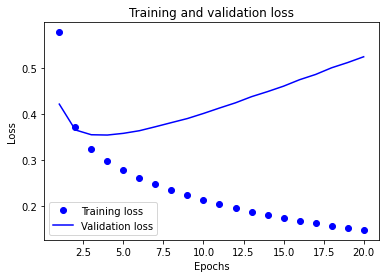

In [24]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

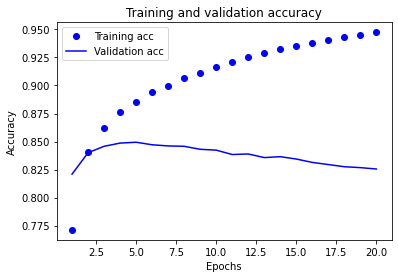

In [25]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

약 3에서 4 이상을 넘어가게 되면 validation loss가 다시 상승하는 것을 그래프를 통해 확인할 수 있다   
또한 accuracy는 3정도를 넘어가면 거의 일정 혹은 점차 감소하는 것을 볼 수 있다  
따라서 epoch를 3으로 설정

아래는 마크다운으로 변경해놓은 2번, 3번 모델들의 결과 그래프이다

## 2번째 모델

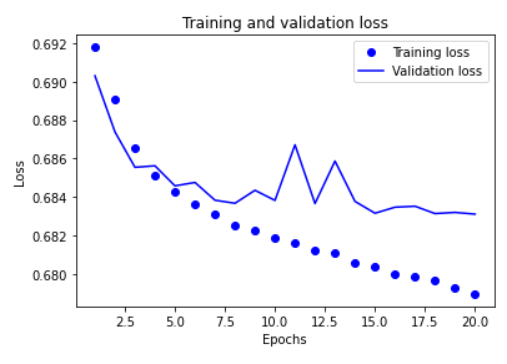   
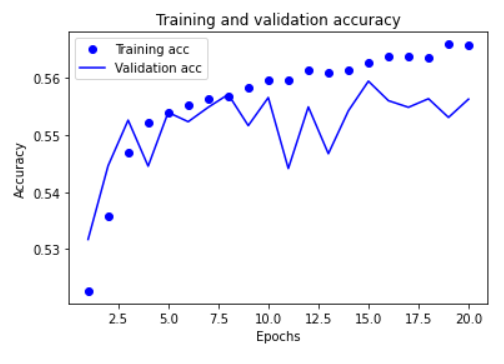

## 3번째 모델
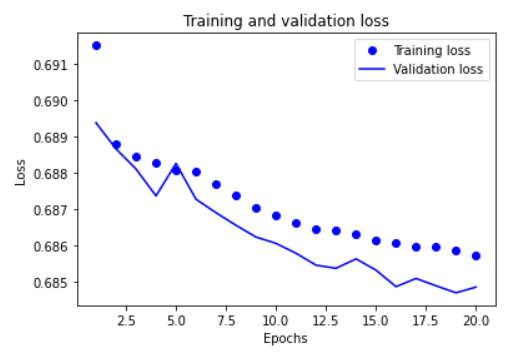
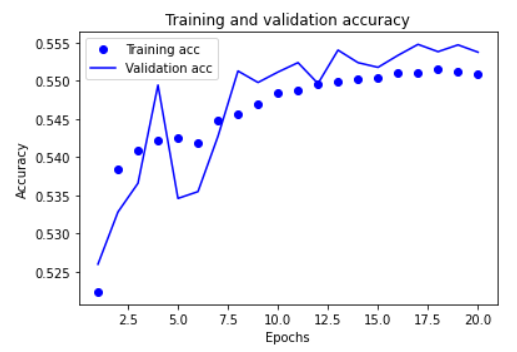

## 2번 모델
2번 모델은 10번을 넘어가면 validtation loss가 살짝 튀긴 하지만 20번까지 봤을때는 계속 추세가 계속 하향인 것을 확인할 수 있다    
하지만 정확도를 보면 계쏙 왔다갔다 하는 모습이 있어 epochs는 8번 정도가 적당하다

## 3번 모델
3번 모델은 5번째에 잠시 위로 튀긴 하지만 추세가 계속 하향하고 있다   
정확도도 5번에 잠시 떨어졌다가 그 이후 계속해서 올라가는 모습을 볼 수 있다.  
약 16번 정도의 epochs 값이 가장 적당한 것으로 보인다


## 버뜨(but)
하지만 두 값다 그래프 상에서의 문제이고 가장 중요한 loss율과 accuracy 값은 1번 모델에 비해 아주 저조한 값을 보이고 있다     
2번 모델은 [0.684904932975769, 0.5542445778846741] // 3번 모델은 [0.6869848370552063, 0.5481823682785034]로   
1번 모델이 월등하게 낫다는 것을 알 수 있다

# 학습된 Embedding layer

In [26]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [27]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [28]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([-0.29633093, -0.26416093, -0.22683634, -0.25290367, -0.27112615,
       -0.2360243 , -0.26145574, -0.23691559, -0.2602873 , -0.23772703,
       -0.2625494 , -0.2180138 , -0.01558167, -0.22473428, -0.30858943,
       -0.2537487 ], dtype=float32)

In [29]:
word_vectors.similar_by_word("영화")

[('을', 0.9911821484565735),
 ('고', 0.9853653907775879),
 ('너무', 0.984872579574585),
 ('...', 0.9810746908187866),
 ('다는', 0.9780244827270508),
 ('메시지', 0.9710837006568909),
 ('하', 0.9707409739494324),
 ('상', 0.9682222008705139),
 ('에서', 0.9656531810760498),
 ('것', 0.9623899459838867)]

이상한 단어들만 나열하고 있다


# ko.bin 사용하기

In [30]:
import gensim

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['영화']
vector     

/tmp/ipykernel_6869/2515942696.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['영화']


array([-1.7577837 , -1.0874279 ,  1.5300866 , -0.1115231 , -0.37980682,
        1.4828517 ,  1.3180419 ,  0.11094163,  0.7430535 , -0.45461136,
        0.58841336,  0.5763913 ,  1.210707  ,  1.3132795 , -0.86962503,
       -0.18507595, -0.47440064,  1.5100725 ,  1.0965794 ,  1.0600823 ,
       -0.27457932, -0.70003706,  2.3117511 ,  1.4944884 ,  0.25560892,
       -2.866659  , -0.28312334,  0.34263936, -0.67723423,  0.71714777,
        0.25549442,  0.71732044, -0.13262457,  0.01792452, -0.3184774 ,
        0.5271619 ,  0.7561084 , -2.1247065 ,  1.061429  , -0.21065854,
        0.6877343 , -1.4956383 ,  0.60346967, -2.6955893 ,  0.37694618,
       -1.0164185 ,  0.5430663 ,  0.1200121 , -2.6315718 ,  0.6216742 ,
        1.1583976 , -2.5385962 ,  1.326312  , -0.10284371, -0.0286147 ,
       -0.9132947 ,  0.7647564 ,  0.79202783, -1.8625957 , -0.7418395 ,
        0.5884277 , -0.9917992 , -0.62114453,  1.5367815 , -0.6628939 ,
        0.6712103 ,  0.12914915,  0.21228492,  0.9017655 , -0.25

In [31]:
word2vec.similar_by_word("영화")

/tmp/ipykernel_6869/2210671227.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("영화")


[('다큐멘터리', 0.7265259027481079),
 ('영화사', 0.715214192867279),
 ('드라마', 0.705294132232666),
 ('뮤지컬', 0.6947016716003418),
 ('코미디', 0.69093257188797),
 ('영화인', 0.6702202558517456),
 ('서부극', 0.6571458578109741),
 ('스릴러', 0.6533164978027344),
 ('로맨스', 0.6428799629211426),
 ('애니메이션', 0.6425570249557495)]

In [32]:
word2vec.similar_by_word("재미")

/tmp/ipykernel_6869/2795643307.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("재미")


[('취미', 0.5857348442077637),
 ('유머', 0.5140613913536072),
 ('매력', 0.5105490684509277),
 ('흥미', 0.4988338351249695),
 ('공짜', 0.4960595667362213),
 ('일자리', 0.49294644594192505),
 ('즐거움', 0.48700767755508423),
 ('비애', 0.4836210310459137),
 ('관객', 0.48286449909210205),
 ('향수', 0.4823310971260071)]

In [33]:
word2vec.similar_by_word("감동")

/tmp/ipykernel_6869/219167998.py:1: DeprecationWarning: Call to deprecated `similar_by_word` (Method will be removed in 4.0.0, use self.wv.similar_by_word() instead).
  word2vec.similar_by_word("감동")


[('감명', 0.7177015542984009),
 ('감격', 0.6908231973648071),
 ('실망', 0.6267645359039307),
 ('감화', 0.6191877126693726),
 ('감탄', 0.6140128374099731),
 ('칭찬', 0.6059398055076599),
 ('존경', 0.6032299995422363),
 ('자극', 0.594598650932312),
 ('감복', 0.5902734994888306),
 ('호응', 0.5850393772125244)]

In [34]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_6869/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_6869/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [35]:
# from tensorflow.keras.initializers import Constant

# vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
# word_vector_dim = 200  # 워드 벡터의 차원 수 

# # 모델 구성
# model = tf.keras.Sequential()
# model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
# model.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
# model.add(tf.keras.layers.Dense(8, activation='relu'))
# model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# model.summary()

In [36]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 35, 16)            22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 16)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [37]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=20 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(X_train, y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
257/257 [==============================] - 20s 8ms/step - loss: 0.5600 - accuracy: 0.6901 - val_loss: 0.4417 - val_accuracy: 0.7961
Epoch 2/20
257/257 [==============================] - 2s 6ms/step - loss: 0.3900 - accuracy: 0.8282 - val_loss: 0.3801 - val_accuracy: 0.8320
Epoch 3/20
257/257 [==============================] - 2s 6ms/step - loss: 0.3295 - accuracy: 0.8604 - val_loss: 0.3590 - val_accuracy: 0.8431
Epoch 4/20
257/257 [==============================] - 2s 6ms/step - loss: 0.2958 - accuracy: 0.8772 - val_loss: 0.3531 - val_accuracy: 0.8454
Epoch 5/20
257/257 [==============================] - 2s 6ms/step - loss: 0.2707 - accuracy: 0.8896 - val_loss: 0.3586 - val_accuracy: 0.8470
Epoch 6/20
257/257 [==============================] - 2s 6ms/step - loss: 0.2498 - accuracy: 0.8992 - val_loss: 0.3766 - val_accuracy: 0.8434
Epoch 7/20
257/257 [==============================] - 2s 6ms/step - loss: 0.2258 - accuracy: 0.9121 - val_loss: 0.3772 - val_accuracy: 0.8468
Epoch

In [38]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7450 - accuracy: 0.8257
[0.7449831366539001, 0.8257420063018799]


In [39]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


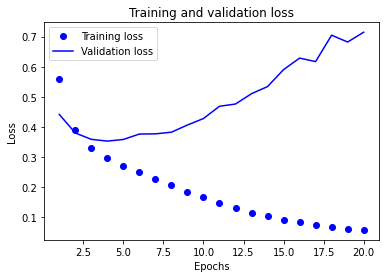

In [40]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

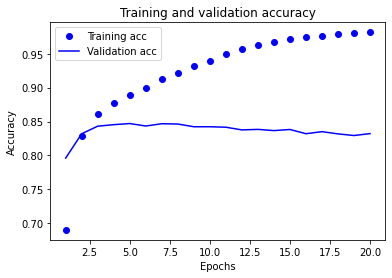

In [41]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# 마무으리(회고)

이번 Exploration 6번은 정말 힘든 과제로 느껴졌다   
cs231과 다양한 것들 때문에 급하게 전날부터 하게된 시간적인 핑계도 있지만, 하필 제출날인 오늘 두통이 강하게 와서 꽤나 어려움을 겪게 만든 노드인 것 같다(머리 아픈건 다 끝나가니까 괜찮아 지는걸 보니 하기싫어서 였을지도....)    
하지만 어찌어찌 계속해서 꾸준히 하고 모르는 건 정말 같은 팀원들과 다른 팀원들에게도 물어보고 겨우겨우 해결해냈던 것 같다

정말 다양한 에러를 만났고 검색해도 안나오는 에러들이라 너무 힘들었다...

그래도 프로젝트 제출을 위해서 꾸준히 붙잡고 하다보니 자연어 처리에 대해 디테일은 아직 어렵지만 전체적인 흐름을 깨닫고 배워가게 됐다.

아직까지 많이 부족한 점은 특히 **데이터 전처리**부분이 많이 부족하다고 생각된다   
이번 프로젝트에는 데이터 처리하는 과정을 코드로 제공해주었기 때문에 좀 수월하게 했지만 만약 혼자 해내야 했다면 불가능하지는 않지만 꽤나 더 많은 시간을 소모했을 것 같다.
또한 모델을 구성하는 것에 대해서 제대로 더 공부를 해야하는데 시간관계상 못하게 된 점도 아쉽다   
물론 5번과 6번 Exploration은 무.적.권 다시 봐야 되는 노드로 짚어야 한다
